In [1]:
import numpy as np
np.random.seed(0)
from utils import *
from training import *
from figure_scripts import *
from models import sorbnet, shallow, dense, pvnet
from optimal_temperature import *
from keras.models import load_model

Using TensorFlow backend.


## Load data for MFI-C5-W system

Please change the first line into the path where you download the data from the MCCCS-DB repository.

Training data contains all 32 independent simulations while test data contains the statistics (means and standard deviations) of 32 simulations at each input.


In [2]:
# Sorption system: MFI-C5-W
X_train, Y_train, _, _ = make_data('../data_publish/', 'MFI-C5-W')
data_eval = make_data('../data_publish/', 'MFI-C5-W', train=False)
X_eval, Y_eval, X_test, Y_test = data_eval


An already-trained model is also provided to skip the training process. Uncomment and run the cell below to load the trained model.

In [10]:
#model = load_model('models/sorbnet-MFI-C5-W.h5')

## Train the neural network

Run the cell below to train the SorbNet and a shallow neural network. The plot will show that SorbNet has faster convergence.

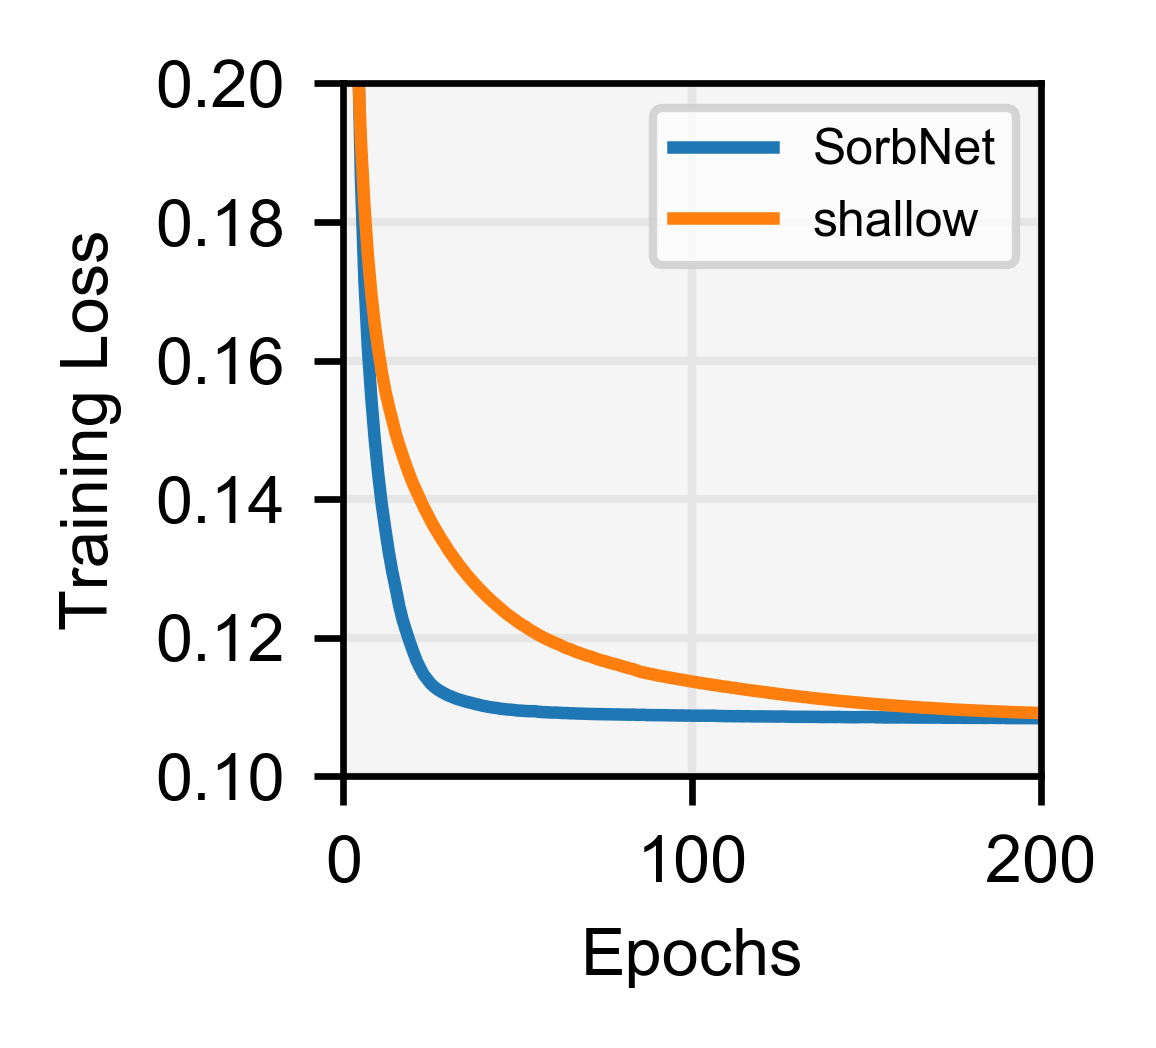

In [3]:
model = sorbnet(4)
callback_sorbnet = train_model(model, (X_train, Y_train))

shallow_net = shallow(4)
callback_shallow = train_model(shallow_net, (X_train, Y_train))
# Plot learning curve
loss_sorbnet = list_history(callback_sorbnet)
loss_shallow = list_history(callback_shallow)
fig, ax = plt.subplots()
fig.set_size_inches(1.5, 1.5)
setup_figure(fig, ax)
ax.plot(loss_sorbnet)
ax.plot(loss_shallow)
ax.set_xlabel("Epochs")
ax.set_ylabel("Training Loss")
ax.set_ylim([0.1, 0.2])
ax.set_xlim([0, 200])
ax.legend(['SorbNet', 'shallow'], fontsize=6)
plt.show()

## Evaluate training and test errors

This cell prints the mean square errors for SorbNet and the shallow network to verify against Table 1, and the plot reproduces Figure 2c.

SorbNet Train MSE: 0.000417409671818639 Test MSE: 0.0009855349383455696
Shallow Train MSE: 0.0004554382922197242 Test MSE: 0.0010225162861894218


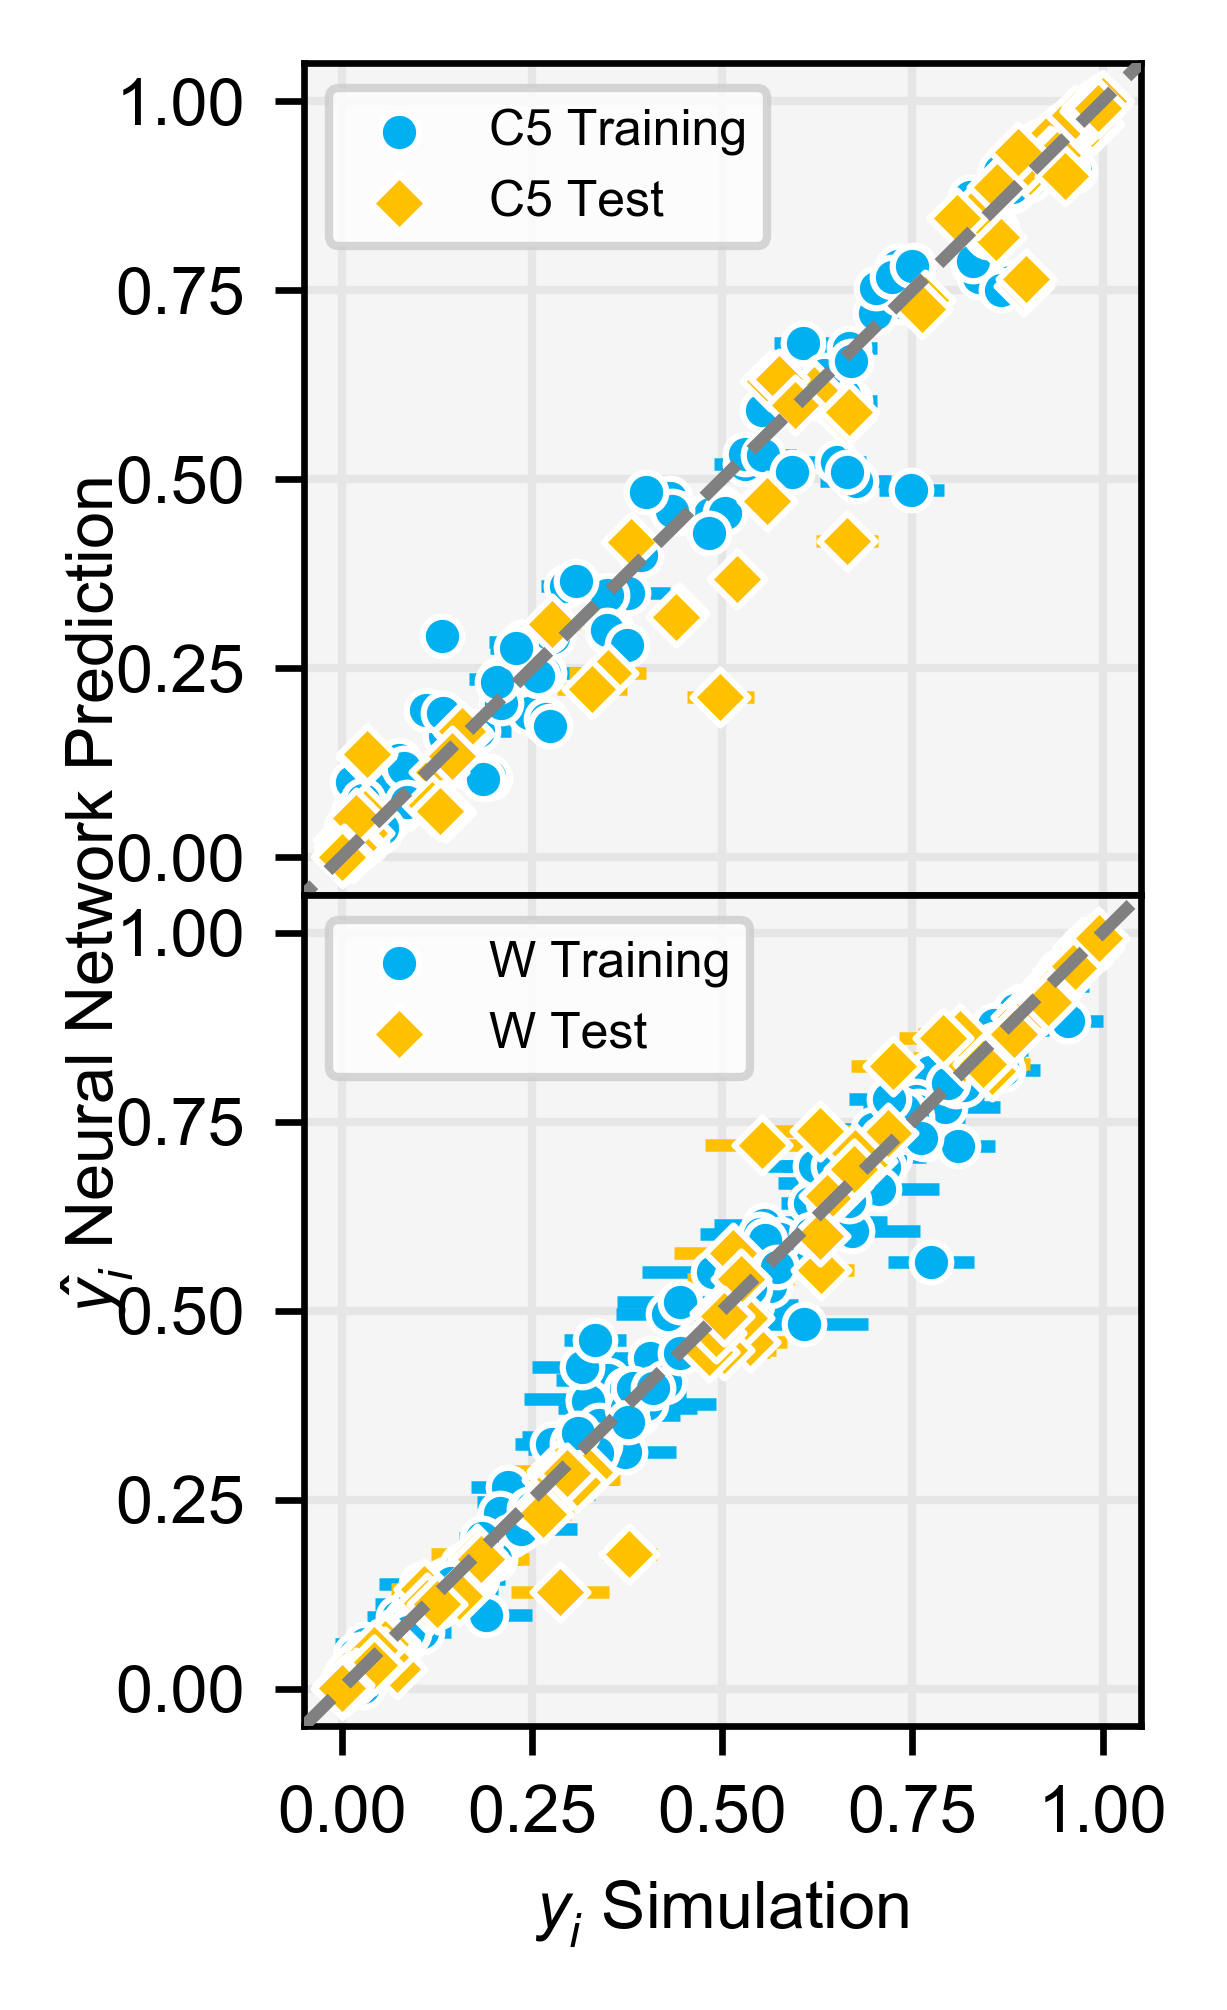

In [12]:
train_res, test_res = eval_model(model, data_eval)
train_res_shallow, test_res_shallow = eval_model(shallow_net, data_eval)

print('SorbNet Train MSE:', calc_mse(train_res), 'Test MSE:', calc_mse(test_res))
print('Shallow Train MSE:',calc_mse(train_res_shallow), 'Test MSE:', calc_mse(test_res_shallow))

parity_plot(train_res, test_res)

## Interpolate Adsorption isotherms

Run this cell to reproduce the plots in Figure 2d.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

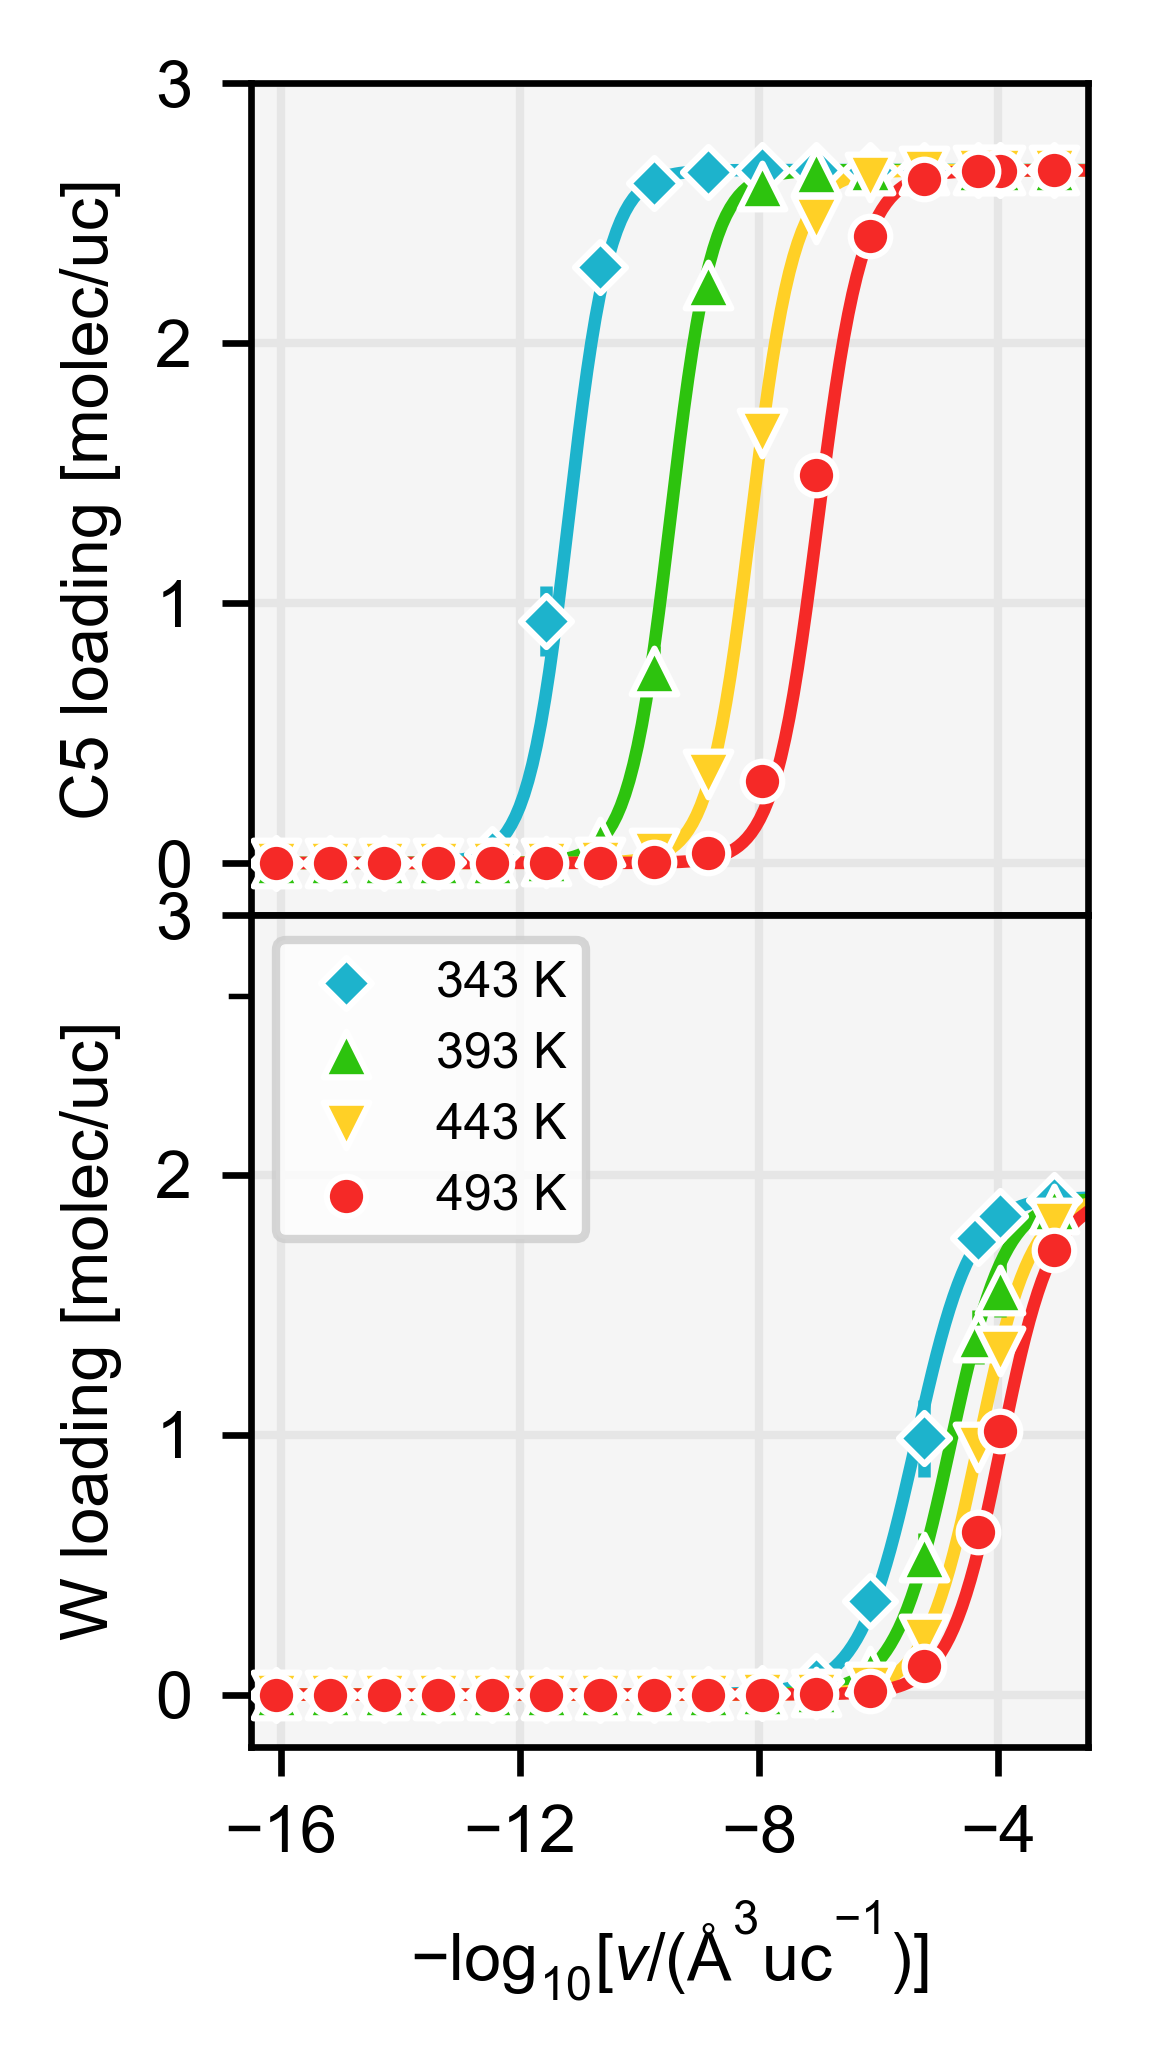

In [13]:
temps = [343, 393, 443, 493]
init = list(set(X_test[:, 2]))[1]
data_true, data_pred = interpolate(model, (X_test, Y_test), temps, init)
isotherm_plot(data_true, data_pred)

## Train p–V neural network.
Run this cell to train the neural network which maps from pressure to volume as described in Section 3.2. The plot reproduces the inset in Figure 3c. Alternatively one can load the already-trained model by uncommenting the second line.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


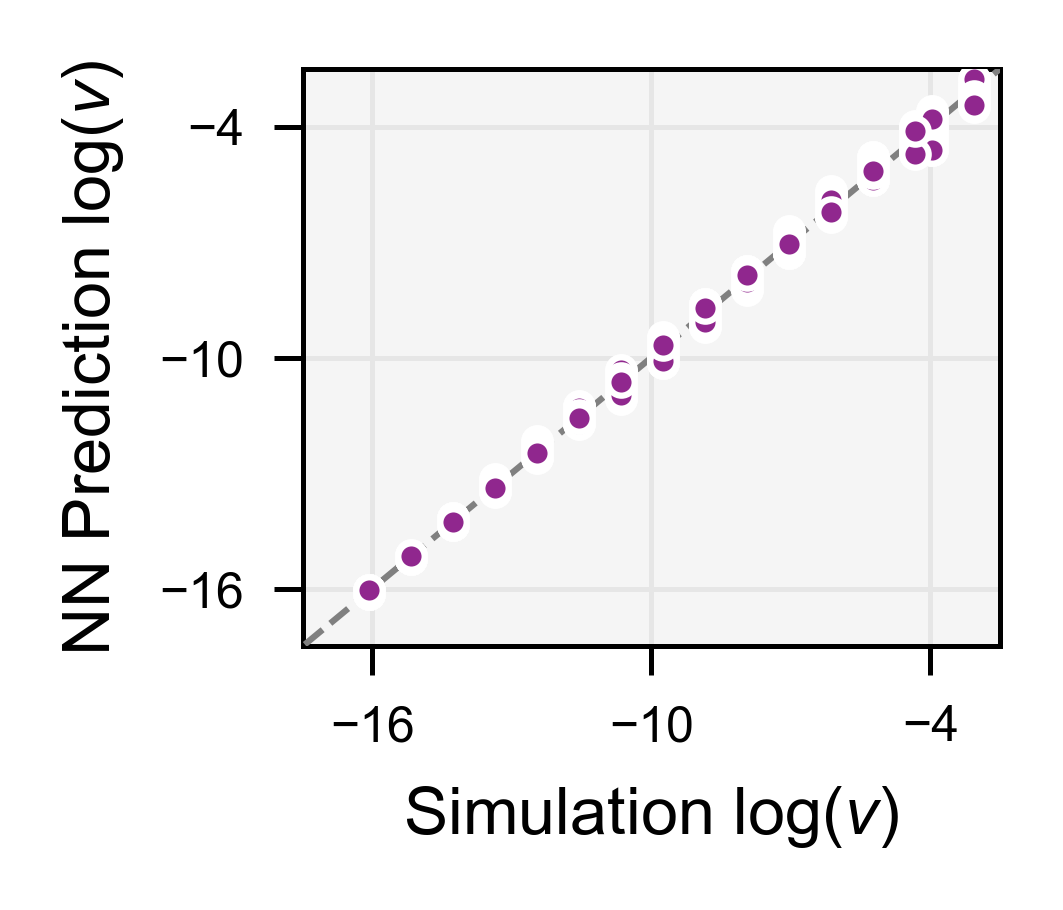

In [15]:
p_model = None
p_model = load_model('models/pvnet-MFI-C5-W.h5')

npt_train = convert_pressure((X_train, Y_train))
npt_eval = convert_pressure((X_eval, Y_eval))
npt_test = convert_pressure((X_test, Y_test))

if not p_model:
    p_model = pvnet(4)
    train_model(p_model, npt_train[::2], loss='mse', epochs=1000, lr=0.001, decay=0)

train_res, test_res = evaluate_pvnet(p_model, npt_eval[::2], npt_test)
parity_plot_pvnet(train_res, test_res)


## Temperature optimizations

####  Note: Due to the randomness of neural network initialization and training, the patterns calculated below may slightly vary. To exactly reproduce Figure 3, both neural networks need to be pre-loaded from the files.

Run this cell to calculate the adsorbed molar ratio as a function of T and p. The plot generated reproduces Figure 3a.

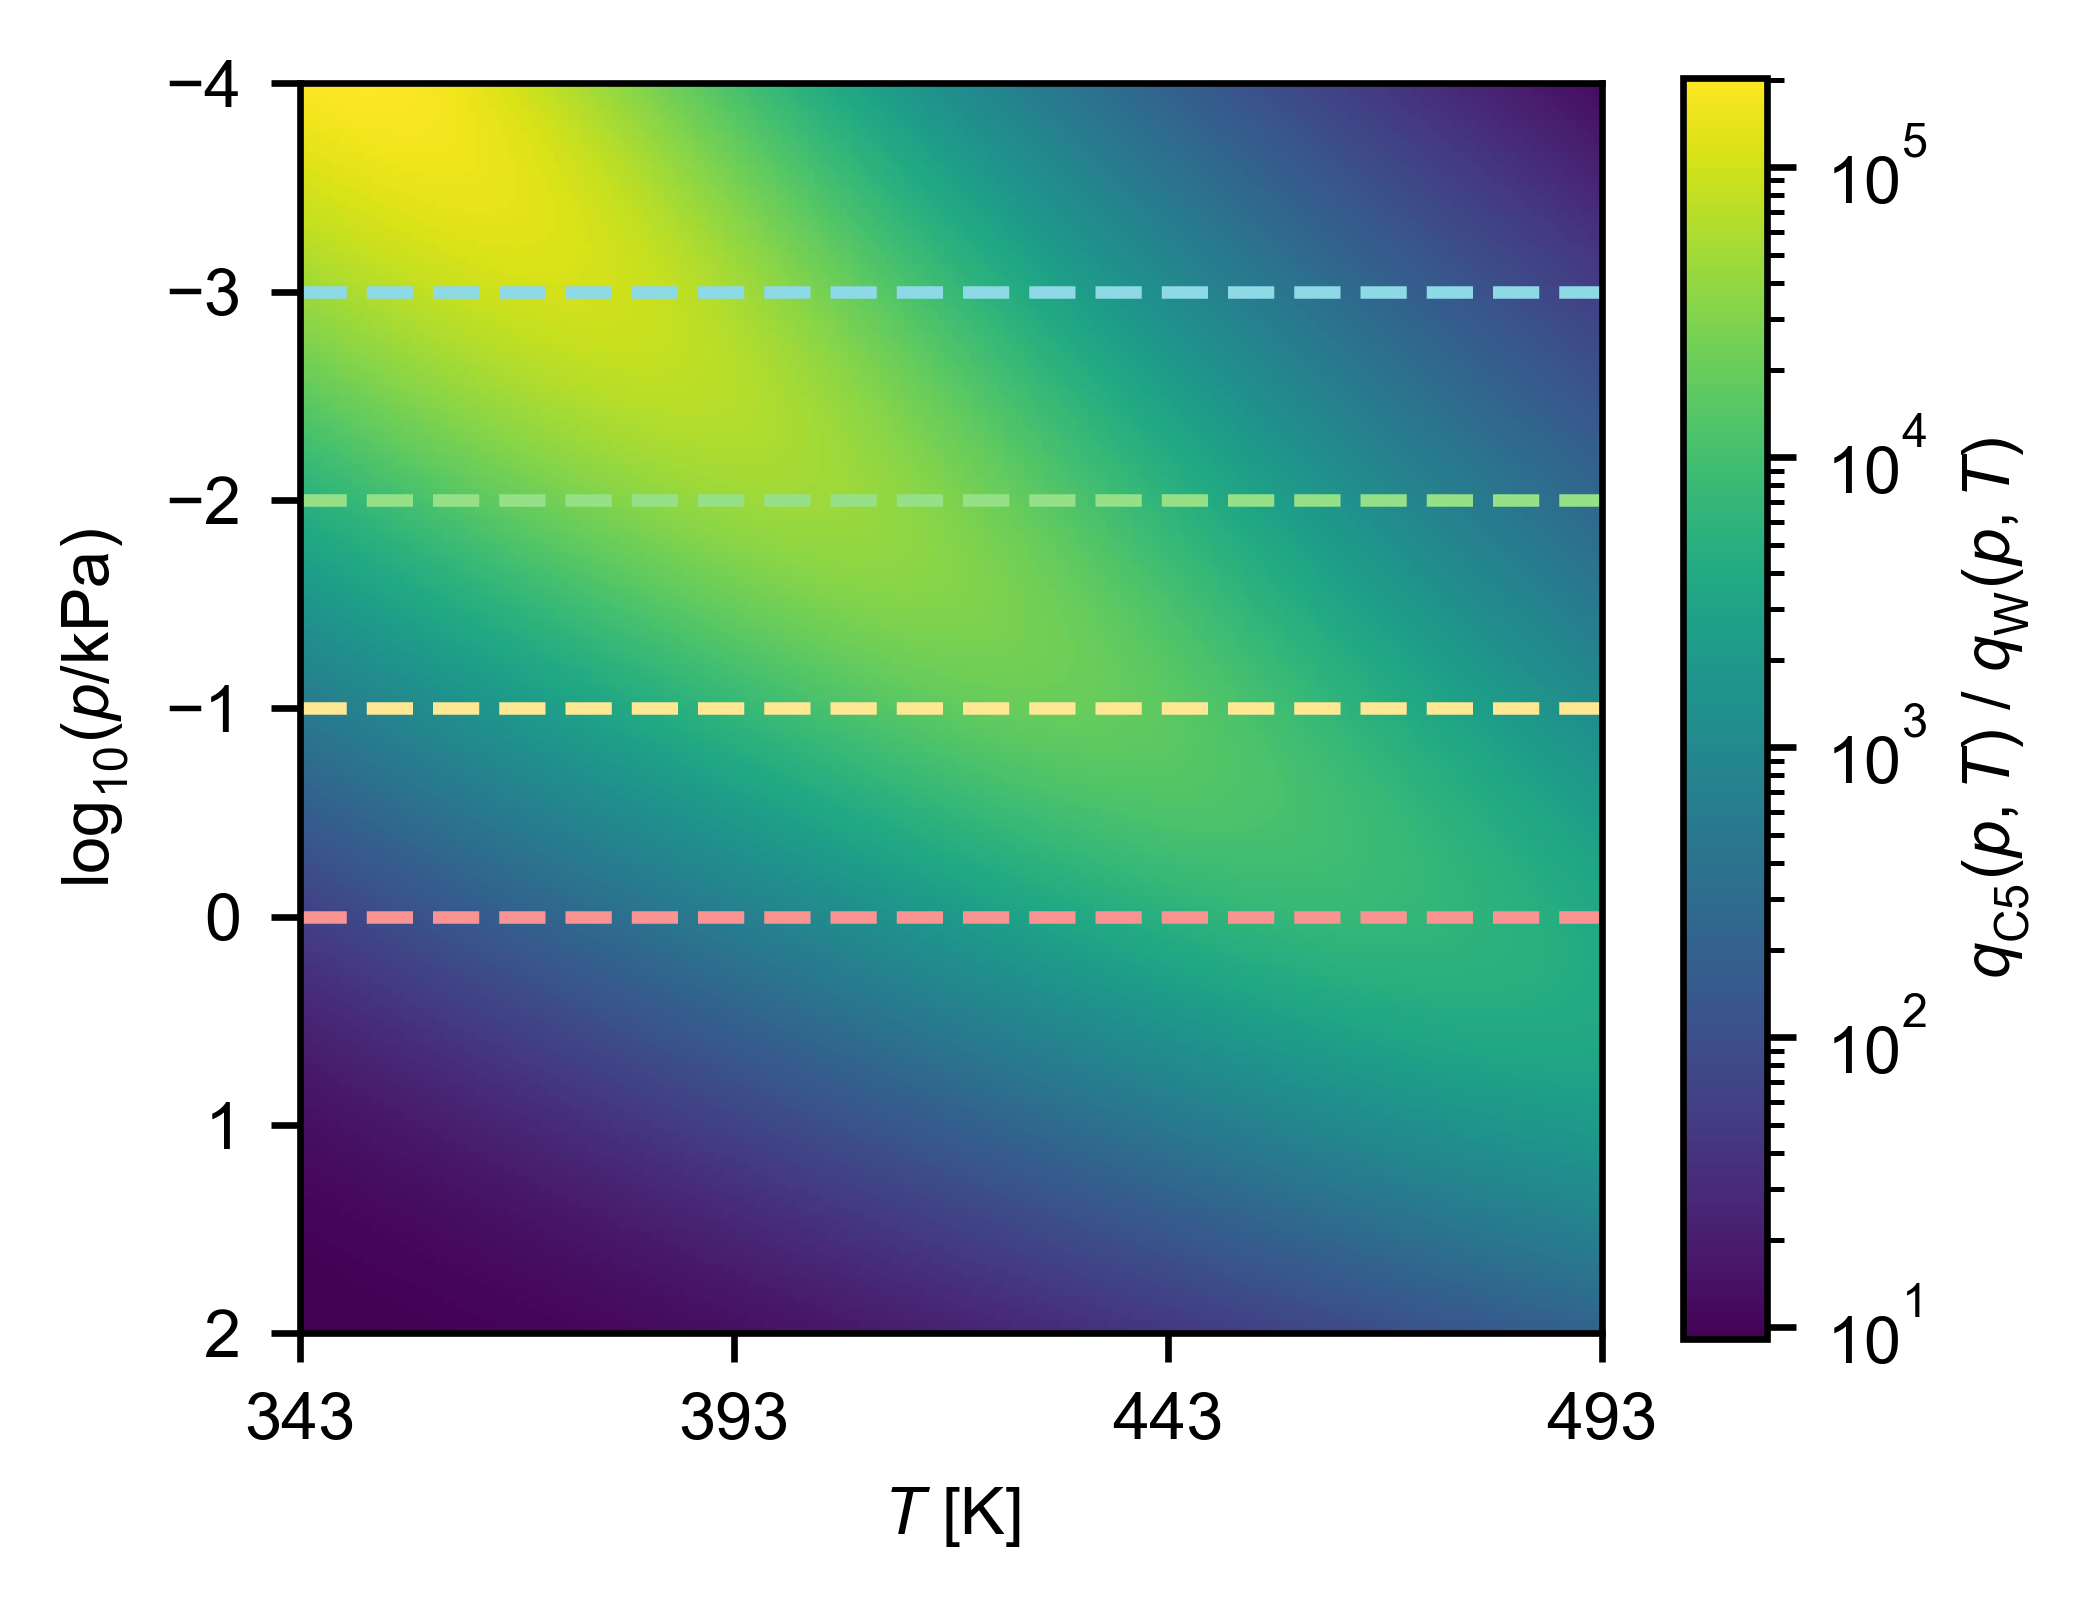

In [21]:
npt_func = get_npt_func(model, p_model)
q1, q2 = loading_image(npt_func, [-4, 2], [343, 493], [7.92, 0.92])
clim = plot_molar_ratio(q1, q2, [-3, -2, -1, 0])

Run this cell to calculate the optimal temperature curves. The plot reproduces Figure 3d.

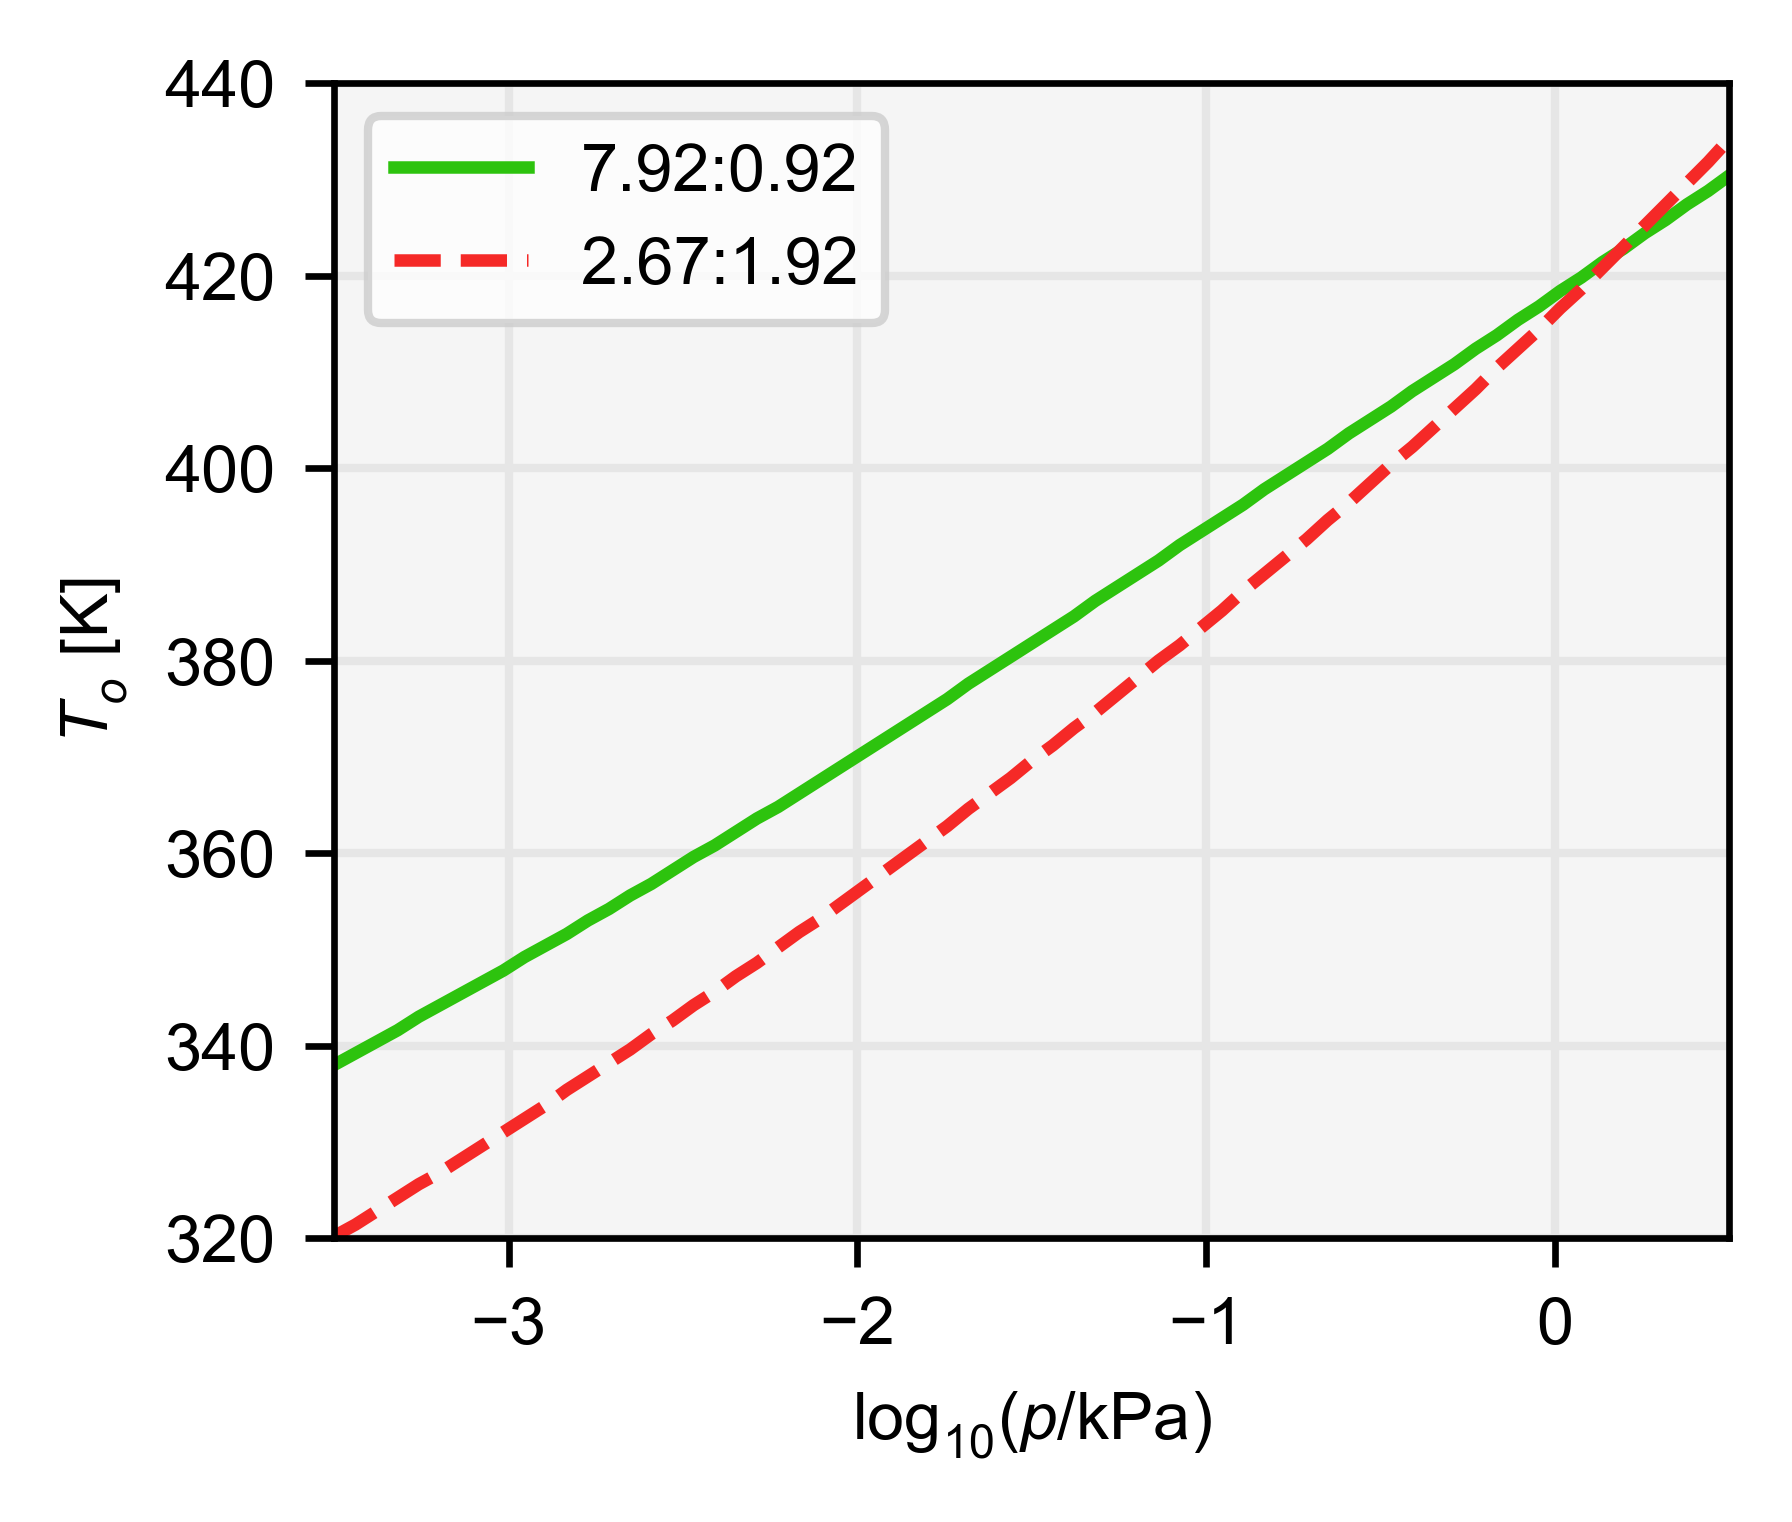

In [17]:
t_curve = optimal_t_curve(npt_func, [-3.5, 2.5], [[7.92, 0.92], [2.67, 1.92]])
plot_temp_curve(t_curve)

Run this cell to plot the isobaric curves of adsorbed molar ratio as well as the constraint boundary. 

If the neural networks are trained in this notebook instead of directed loaded, the constraint boundary may look different and instersects with an isobaric curve twice due to numerical sensitivities in calculating the ratio.

In this case, the intersection before the peak occurs corresponds to the optimal temperature, as after the first intersection the diol fraction already drops below 99%.

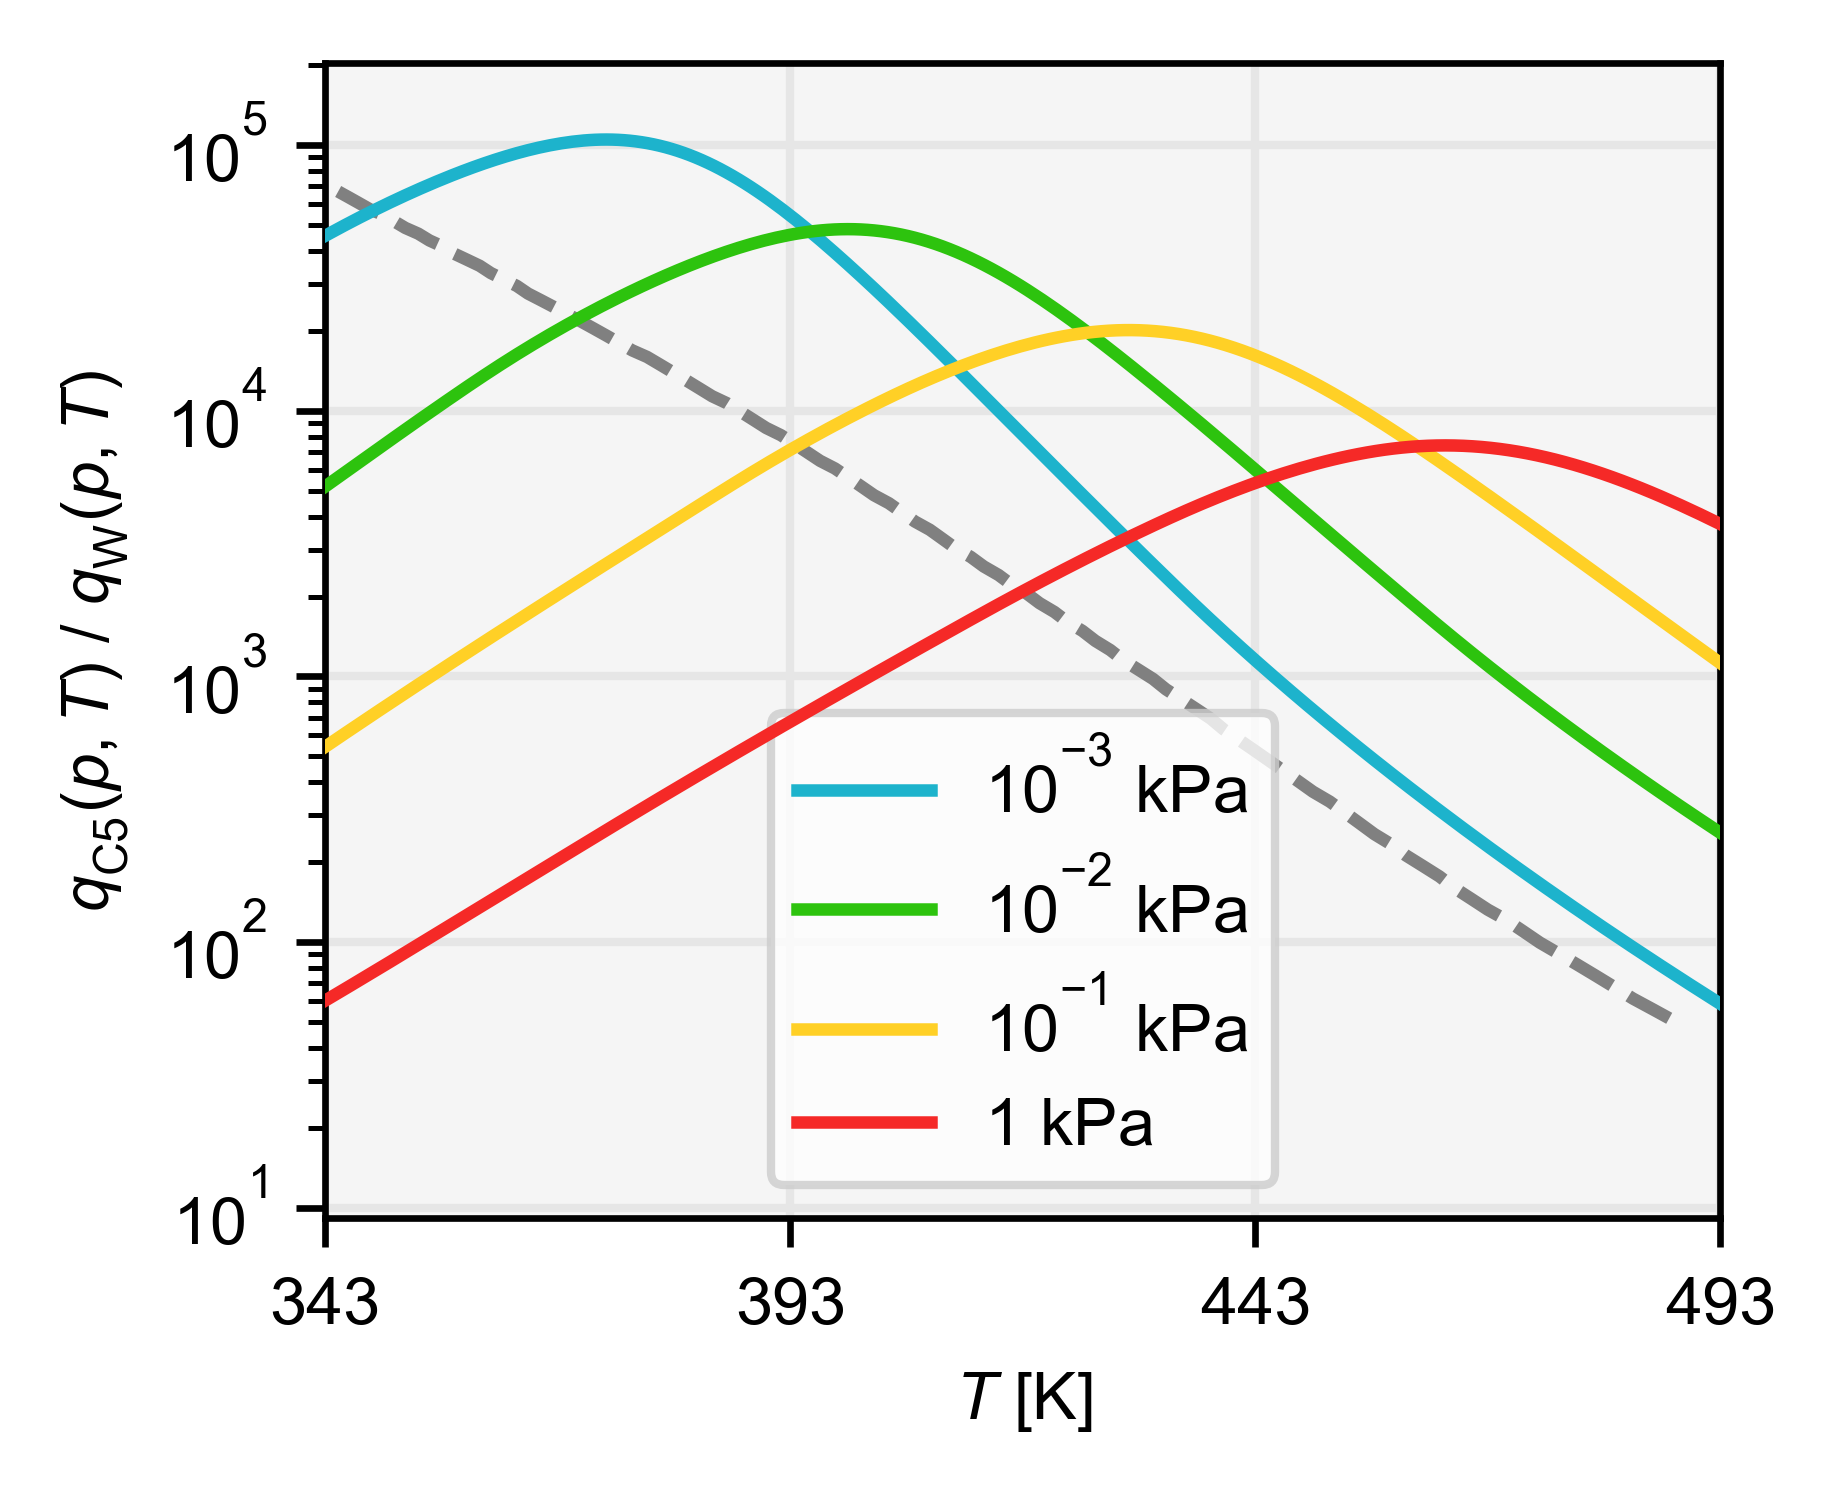

In [19]:
isobaric_loading = isobaric_curve(npt_func, [-3, -2, -1, 0], [343, 493], [7.92, 0.92])
plot_isobaric_ops(isobaric_loading, t_curve, clim)